In [34]:
import pandas as pd

df = pd.read_csv("College_Football_Elo_Rankings_PerSeason.csv")

In [35]:
def clean_team_name(name):
    if pd.isna(name):
        return name
    return (
        name.strip()
            .lower()
            .replace('.', '')
            .replace('&', 'and')
            .replace('st ', 'state ')
            .replace('univ', 'university')
    )

df['Team'] = df['Team'].apply(clean_team_name)
df['opponent'] = df['opponent'].apply(clean_team_name)


In [ ]:
opp_elo = df[['Team', 'season', 'week', 'Team_Elo_Rating']].rename(
    columns = {'Team':'opponent', 'Team_Elo_Rating':'Opponent_Elo_Rating'})

df = df.merge(opp_elo, on = ['opponent', 'season', 'week'], how = 'left')

df.head()

In [ ]:
df['margin'] = df['points_scored'] - df['points_allowed']
df['is_win'] = (df['points_scored'] > df['points_allowed']).astype(int)
df['home_bool'] = df['home_game'].astype(int)
df['prev_ap_rank'] = df.groupby(['Team', 'season'])['AP_rank'].shift(1)
df['rank_change'] = df['prev_ap_rank'] - df['AP_rank']

df['win_streak'] = df.groupby(['Team', 'season'])['is_win'].transform(
    lambda x: x.rolling(3, min_periods = 1).sum()
)
df['avg_margin_last3'] = df.groupby(['Team', 'season'])['margin'].transform(
    lambda x: x.rolling(3, min_periods = 1).mean()
)

In [ ]:
features = ['previous_ap_rank', 'Team_Elo_Rating', 'Opponent_Elo_Rating',
            'elo_diff', 'is_win', 'margin', 'home_bool', 'win_streak', 
            'avg_margin_last3']

y = df['rank_change']

In [ ]:
train = df[df['season'] < 2024]
test = df[df['season'] == 2024]
X_train, y_train = train[features], train['rank_change']
X_test, y_test = test[features], test['rank_change']

In [ ]:
import pandas as pd

df = pd.read_csv("04 - Elo Space/College_Football_Elo_Rankings.csv")
print(df.shape)
print(df.columns)
print(df.head(5))

(5599, 30)
Index(['Unnamed: 0', 'week', 'season', 'Team', 'opponent', 'code', 'date',
       'Result', 'OT', 'OT_num', 'pass', 'rush', 'rec', 'points_allowed',
       'points_scored', 'point_differential', 'home_game', 'CONF', 'SOR',
       'FPI', 'SOS', 'GC', 'AVGWP', 'AP_rank', 'opponent_rank', 'rank_change',
       'full_date_str', 'game_date', 'sept_1_date', 'Team_Elo_Rating'],
      dtype='object')
   Unnamed: 0  week  season              Team         opponent  code  \
0        2261     2    2021      Fresno State           Oregon   278   
1        2266     2    2021          Illinois             UTSA   356   
2        2282     2    2021  New Mexico State  San Diego State   166   
3        2296     2    2021    San Jose State              USC    23   
4        2313     2    2021              UCLA              LSU    26   

         date Result     OT OT_num  ...  SOS   GC  AVGWP  AP_rank  \
0  Sat, Sep 4      L  False    NaN  ...   95   37     19      NaN   
1  Sat, Sep 4      L  

In [45]:
import pandas as pd

# Load data
df = pd.read_csv("College_Football_Elo_Rankings_PerSeason.csv")

# -------------------------------
# 1️⃣ Clean team and opponent names
# -------------------------------
def clean_team_name(name):
    if pd.isna(name):
        return name
    return (
        name.strip()
            .lower()
            .replace('.', '')
            .replace('&', 'and')
            .replace('st ', 'state ')
            .replace('univ', 'university')
    )

df['Team'] = df['Team'].apply(clean_team_name)
df['opponent'] = df['opponent'].apply(clean_team_name)

# ----------------------------------
# 2️⃣ Merge opponent Elo information
# ----------------------------------
opp_elo = df[['Team', 'season', 'game_date', 'Post_Elo_Team']].rename(
    columns={'Team': 'opponent', 'Post_Elo_Team': 'Opponent_Elo_Rating'}
)

df = df.merge(opp_elo, on=['opponent', 'season', 'game_date'], how='left')

# ----------------------------------
# 3️⃣ Create features for modeling
# ----------------------------------
df['Team_Elo_Rating'] = df['Post_Elo_Team']  # clearer naming
df['elo_diff'] = df['Team_Elo_Rating'] - df['Opponent_Elo_Rating']

# Example game stats (these may need to be merged from your other file)
df['margin'] = df['point_differential']
df['is_win'] = (df['Result'] == 'W').astype(int)

# Placeholder features you’ll calculate later
df['home_bool'] = 0  # replace if you have a 'home_game' flag
df['win_streak'] = df.groupby(['Team', 'season'])['is_win'].transform(lambda x: x.rolling(3, min_periods=1).sum())
df['avg_margin_last3'] = df.groupby(['Team', 'season'])['margin'].transform(lambda x: x.rolling(3, min_periods=1).mean())

# ----------------------------------
# 4️⃣ Define model-ready features
# ----------------------------------
features = [
    'prev_ap_rank', 'Team_Elo_Rating', 'Opponent_Elo_Rating',
    'elo_diff', 'is_win', 'margin', 'home_bool', 
    'win_streak', 'avg_margin_last3'
]

# Drop rows missing target or critical features
df = df.dropna(subset=['rank_change'] + features)

# ----------------------------------
# 5️⃣ Train/test split for seasons
# ----------------------------------
train = df[df['season'] < 2024]
test = df[df['season'] == 2024]

X_train, y_train = train[features], train['rank_change']
X_test, y_test = test[features], test['rank_change']

# ----------------------------------
# 6️⃣ Save clean dataset for modeling
# ----------------------------------
df.to_csv("Model_Ready_AP_Rank_Data.csv", index=False)
print("✅ Saved clean file as Model_Ready_AP_Rank_Data.csv")


KeyError: ['rank_change', 'prev_ap_rank']

In [40]:
print(df.columns.tolist())

['season', 'game_date', 'Team', 'opponent', 'Result', 'point_differential', 'Pre_Elo_Team', 'Pre_Elo_Opponent', 'Post_Elo_Team', 'Post_Elo_Opponent', 'Elo_Change']


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
import joblib

# Load data
df = pd.read_csv("College_Football_Elo_Rankings_PerSeason.csv")

# Drop rows missing the target or key game stats
df = df.dropna(subset=["rank_change", "points_scored", "points_allowed", "Team_Elo_Rating"])

# Define features and target
features = [
    "Team", "opponent", "home_game", "points_scored", "points_allowed",
    "point_differential", "AP_rank", "opponent_rank", "Team_Elo_Rating"
]
X = df[features]
y = df["rank_change"]

# Identify categorical and numeric columns
categorical = ["Team", "opponent", "home_game"]
numeric = [col for col in features if col not in categorical]

# Preprocessing pipeline with imputers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, categorical)
    ]
)

# Full pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=300, random_state=42))
])

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))

# Save trained model
joblib.dump(model, "ap_rank_change_model.pkl")


KeyError: ['rank_change', 'points_scored', 'points_allowed', 'Team_Elo_Rating']

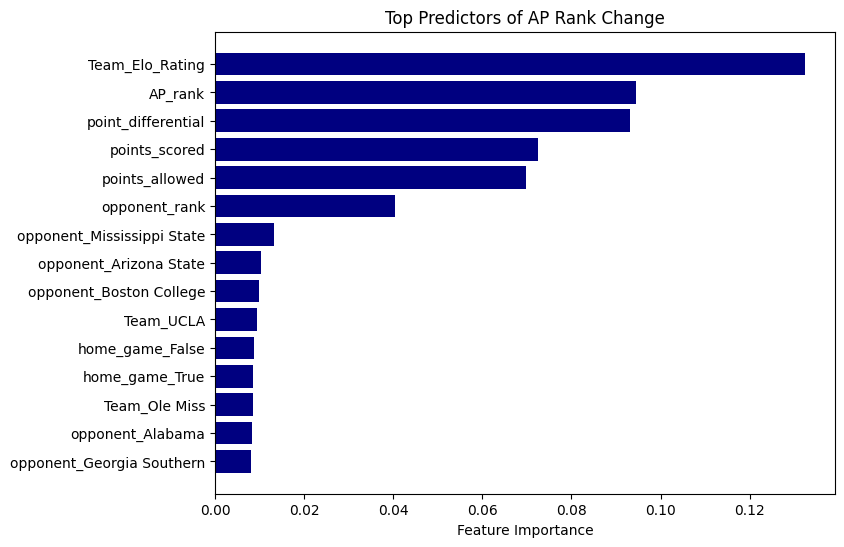

In [14]:
df = pd.read_csv("04 - Elo Space/College_Football_Elo_Rankings.csv")

df['elo_rank_weekly'] = df.groupby(['season', 'week'])['Team_Elo_Rating'].rank(ascending = False, method = "dense")

df['AP_rank_filled'] = df['AP_rank'].fillna(df['elo_rank_weekly'])

df['opponent_rank_filled'] = df['opponent_rank'].fillna(df.groupby(['season', 'week'])
                                                        ['Team_Elo_Rating'].rank(ascending = False, method = 'dense'))

In [15]:
# Keep only games where the team had an AP rank (so both are available)
ranked = df.dropna(subset=["AP_rank", "Team_Elo_Rating"])

# Correlation (Pearson)
corr = ranked["AP_rank"].corr(ranked["Team_Elo_Rating"])
print(f"Correlation between AP rank and ELO: {corr:.3f}")


Correlation between AP rank and ELO: -0.561


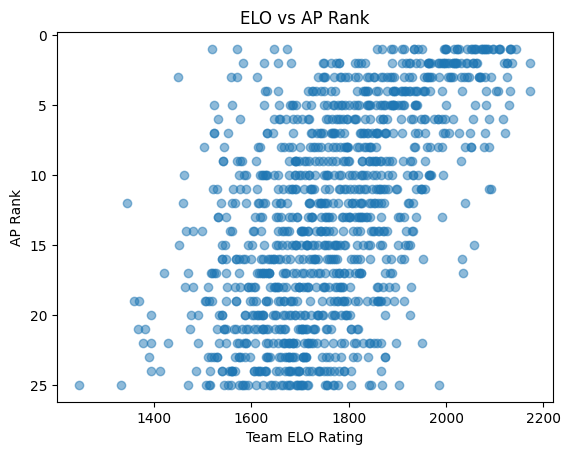

In [16]:
import matplotlib.pyplot as plt

plt.scatter(ranked["Team_Elo_Rating"], ranked["AP_rank"], alpha=0.5)
plt.xlabel("Team ELO Rating")
plt.ylabel("AP Rank")
plt.title("ELO vs AP Rank")
plt.gca().invert_yaxis()  # since #1 is better than #25
plt.show()


Percentile correlation: 0.552


C:\Users\joshg\AppData\Local\Temp\ipykernel_60964\3171521558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranked["elo_percentile"] = rankdata(ranked["Team_Elo_Rating"], method="average") / len(ranked)
C:\Users\joshg\AppData\Local\Temp\ipykernel_60964\3171521558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranked["ap_percentile"] = rankdata(-ranked["AP_rank"], method="average") / len(ranked)  # invert since #1 is best
